In [1]:
import pandas as pd
import zipfile
import numpy as np
import emoji
import re, string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
seed_value= 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Get Data

In [3]:
with zipfile.ZipFile('disaster_tweet.zip') as zip_ref:
    zip_ref.extractall()

In [4]:
df = pd.read_csv('tweets.csv')

In [5]:
df.head(20)

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1
8,8,ablaze,"Accra, Ghana","National Security Minister, Kan Dapaah's side ...",0
9,9,ablaze,Searching,This creature who’s soul is no longer clarent ...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 11370 entries, 0 to 11369

Data columns (total 5 columns):

 #   Column    Non-Null Count  Dtype 

---  ------    --------------  ----- 

 0   id        11370 non-null  int64 

 1   keyword   11370 non-null  object

 2   location  7952 non-null   object

 3   text      11370 non-null  object

 4   target    11370 non-null  int64 

dtypes: int64(2), object(3)

memory usage: 444.3+ KB


In [7]:
df = df.filter(['text', 'target'])
df = df.drop_duplicates()

# Check Target distribution

<AxesSubplot:>

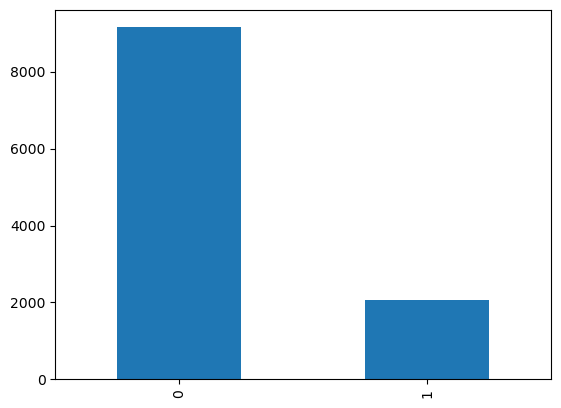

In [8]:
df['target'].value_counts().plot(kind='bar')

# Balance labels

In [9]:
df = pd.concat([df[df['target'] == 1], df[df['target'] == 0][:2071]], axis=0)
df = df.reset_index(drop=True)
df['target'].value_counts()

1    2071
0    2071
Name: target, dtype: int64

# Clean text for Bert model

In [10]:
def clean_text(text):
    return strip_mult_spaces(clean_hashtags(strip_punctuation(strip_urls(strip_emoji(text)))))
    
def strip_emoji(text):
    for e in emoji.distinct_emoji_list(text):
      text = re.sub(e, r"", text)
    return text

def strip_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    return text

def strip_urls(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r'http\S+', '', text)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

def strip_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [11]:
for i in range(5):
    print(f"OLD: {df['text'][i]}")
    print('-'*50)
    print(f"NEW: {clean_text(df['text'][i])}")
    print('\n\n\n\n')

OLD: Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze…

--------------------------------------------------

NEW: communal violence in bhainsa telangana stones were pelted on muslims houses and some houses and vehicles were set ablaze…











OLD: Telangana: Section 144 has been imposed in Bhainsa from January 13 to 15, after clash erupted between two groups on January 12. Po…

--------------------------------------------------

NEW: telangana section 144 has been imposed in bhainsa from january 13 to 15 after clash erupted between two groups on january 12 po…











OLD: Arsonist sets cars ablaze at dealership https://t.co/gOQvyJbpVI

--------------------------------------------------

NEW: arsonist sets cars ablaze at dealership











OLD: Arsonist sets cars ablaze at dealership https://t.co/0gL7NUCPlb https://t.co/u1CcBhOWh9

--------------------------------------------------

NEW: arsonist sets 

In [12]:
df['text'] = df['text'].apply(clean_text)

## Remove text that are less than 8 characters long

In [13]:
df[df['text'].str.len() < 8]

,text,target
2310,…,0
3308,i will,0
3974,spot on,0


In [14]:
df = df[df['text'].str.len() > 8]
df = df.reset_index(drop=True)

# Split data into train, valid, and test

In [15]:
max_len = df['text'].str.len().max()
max_len

138

In [16]:
x_train, x_data, y_train, y_data = train_test_split(df['text'].values, df['target'].values, train_size=0.73, stratify=df['target'], random_state=seed_value)
x_valid, x_test, y_valid, y_test = train_test_split(x_data, y_data, test_size=0.3, stratify=y_data, random_state=seed_value)

In [17]:
len(x_train), len(x_valid), len(x_test)

(3019, 781, 336)

# Load model and tokenizer

In [18]:
from transformers import TFBertModel, BertTokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']

- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.

If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Create tokenizing function and tokenize data

In [19]:
def tokenize(data,max_len=max_len) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [20]:
train_input_ids, train_attention_masks = tokenize(x_train, max_len)
valid_input_ids, valid_attention_masks = tokenize(x_valid, max_len)
test_input_ids, test_attention_masks = tokenize(x_test, max_len)

# Create model and train

In [21]:
def create_model(bert_model, max_len=max_len):
    
    input_ids = Input(shape=(max_len,),dtype='int32')
    
    attention_masks = Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = Dense(1, activation="sigmoid")(embeddings)
    
    model = Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    
    return model

In [22]:
model = create_model(bert_model, max_len)
model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 138)]        0           []                               

                                                                                                  

 input_2 (InputLayer)           [(None, 138)]        0           []                               

                                                                                                  

 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                

                                thPoolingAndCrossAt               'input_2[0][0]']                

                                tentions(last_hidde                                               

                                n_state=(None, 138,                                

In [23]:
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([valid_input_ids,valid_attention_masks], y_valid), epochs=3, batch_size=32)

Epoch 1/3

95/95 [==============================] - 1528s 16s/step - loss: 0.4711 - accuracy: 0.7824 - val_loss: 0.3436 - val_accuracy: 0.8643

Epoch 2/3

95/95 [==============================] - 1474s 16s/step - loss: 0.3116 - accuracy: 0.8804 - val_loss: 0.3172 - val_accuracy: 0.8822

Epoch 3/3

95/95 [==============================] - 1482s 16s/step - loss: 0.2159 - accuracy: 0.9245 - val_loss: 0.3165 - val_accuracy: 0.8848


# Plot loss and accuracy of model

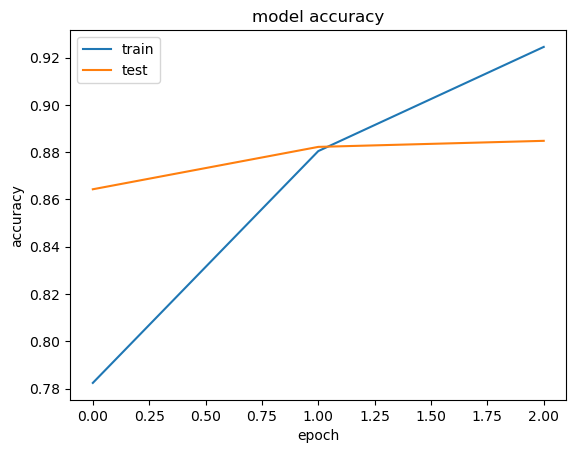

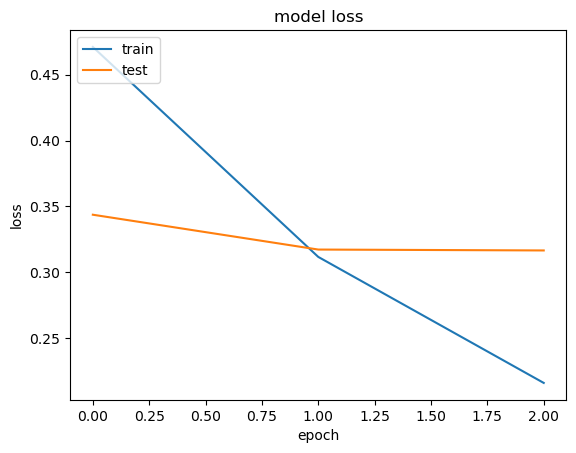

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Confusion matrix and classification report

11/11 [==============================] - 55s 5s/step

              precision    recall  f1-score   support



           0       0.92      0.79      0.85       168

           1       0.82      0.93      0.87       168



    accuracy                           0.86       336

   macro avg       0.87      0.86      0.86       336

weighted avg       0.87      0.86      0.86       336




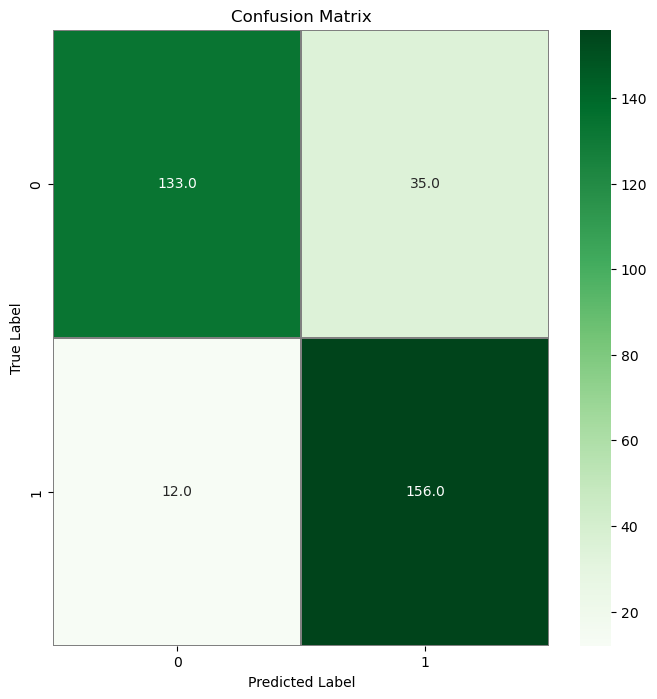

In [25]:
y_pred = model.predict([test_input_ids, test_attention_masks])
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))
confusion_mtx = confusion_matrix(y_test, y_pred)

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()